In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [2]:
stocks = pd.read_csv("./data/EA_stocks_Mar_Jun_2016.csv")
twitter = pd.read_csv("./data/EA_tweets_BERT.csv")

stocks["Date"] = pd.to_datetime(stocks["Date"], format="%Y-%m-%d")
twitter["Date"] = pd.to_datetime(twitter["Date"], format="%Y-%m-%d")

In [3]:
twitter["Sentiment"] = twitter["Sentiment"].replace({0: "Negative", 1: "Positive"})

In [4]:
daily_pos = pd.DataFrame(twitter.groupby("Date").apply(lambda x: x[x["Sentiment"]=="Positive"]["Date"].count()))
daily_neg = pd.DataFrame(twitter.groupby("Date").apply(lambda x: x[x["Sentiment"]=="Negative"]["Date"].count()))
daily_neu = pd.DataFrame(twitter.groupby("Date").apply(lambda x: x[x["Sentiment"]=="Neutral"]["Date"].count()))
volume_per_day = pd.DataFrame(twitter.groupby("Date")["Sentiment"].count())

twitter_copy = twitter.copy()
twitter_copy = twitter_copy.groupby("Date").mean()

twitter_copy["daily_pos"], twitter_copy["daily_neg"], \
    twitter_copy["daily_neu"], twitter_copy["Tweet Volume"] = daily_pos, daily_neg, \
                                                              daily_neu, volume_per_day

twitter_copy["Percent Positive"] = twitter_copy["daily_pos"] / twitter_copy["Tweet Volume"]
twitter_copy["Percent Negative"] = twitter_copy["daily_neg"] / twitter_copy["Tweet Volume"]
twitter_copy["Percent Neutral"] = twitter_copy["daily_neu"] / twitter_copy["Tweet Volume"]

to_drop = ["daily_neu", "Percent Neutral"]
twitter_copy.drop(to_drop, axis=1, inplace=True)

twitter_copy.head()                                

,RTs,Followers,Following,daily_pos,daily_neg,Tweet Volume,Percent Positive,Percent Negative
Date,,,,,,,,
2016-03-27,4.000000,1249.000000,241.500000,4,0,4,1.000000,0.000000
2016-03-28,4.235294,3731.804878,1503.925000,38,3,41,0.926829,0.073171
2016-03-29,4.375000,4476.458333,1266.430556,62,10,72,0.861111,0.138889
2016-03-30,1.000000,1897.916667,636.625000,56,4,60,0.933333,0.066667
2016-03-31,7.125000,4840.074074,2673.846154,26,1,27,0.962963,0.037037


In [5]:
stocks["high_low_pct"] = (stocks["High"] - stocks["Low"]) / stocks["Low"]
stocks["close_open_pct"] = (stocks["Close"] - stocks["Open"]) / stocks["Open"]
# historic price change
stocks["Close(t-1)"] = stocks["Close"].shift(1)
stocks["% Price Change"] = (stocks["Close"] - stocks["Close(t-1)"]) / stocks["Close(t-1)"] * 100

# stocks["Stock Movement"] = (stocks["Closing Percent Change"] > 0).astype(int)

stocks = stocks.set_index("Date")

In [6]:
stock_sentiment = twitter_copy.merge(stocks, left_index=True, right_index=True)
stock_sentiment["Close_MA"] = stock_sentiment["Close"].rolling(2).mean()
stock_sentiment["Close(t-1)"] = stock_sentiment["Close"].shift(1)
stock_sentiment["Close(t-2)"] = stock_sentiment["Close"].shift(2)
stock_sentiment = stock_sentiment[2:]
stock_sentiment.head()

,RTs,Followers,Following,daily_pos,daily_neg,Tweet Volume,Percent Positive,Percent Negative,Open,High,Low,Close,Adj Close,Volume,high_low_pct,close_open_pct,Close(t-1),% Price Change,Close_MA,Close(t-2)
Date,,,,,,,,,,,,,,,,,,,,
2016-03-30,1.000000,1897.916667,636.625000,56,4,60,0.933333,0.066667,66.730003,67.160004,66.279999,66.410004,65.718712,2458300,0.013277,-0.004795,66.029999,0.575504,66.220001,64.639999
2016-03-31,7.125000,4840.074074,2673.846154,26,1,27,0.962963,0.037037,66.330002,67.099998,65.699997,66.110001,65.421837,2265000,0.021309,-0.003317,66.410004,-0.451744,66.260002,66.029999
2016-04-01,12.000000,10194.583333,3061.590909,23,1,24,0.958333,0.041667,65.360001,66.120003,65.129997,65.919998,65.233818,2160500,0.015200,0.008568,66.110001,-0.287404,66.015000,66.410004
2016-04-04,2.333333,17777.812500,593.733333,14,2,16,0.875000,0.125000,66.000000,66.489998,65.379997,65.739998,65.055679,2029600,0.016978,-0.003939,65.919998,-0.273058,65.829998,66.110001
2016-04-05,2.263158,1688.044444,1141.777778,40,6,46,0.869565,0.130435,65.099998,65.959999,65.050003,65.449997,64.768715,2281800,0.013989,0.005376,65.739998,-0.441133,65.594998,65.919998


### XGBoost Regressor

In [7]:
import xgboost as xgb

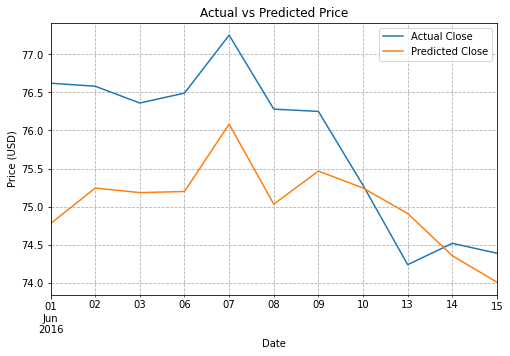

In [8]:
split = math.ceil(len(stock_sentiment) * 0.8)

train = stock_sentiment[:split]
test = stock_sentiment[split:]

predictors = ["Percent Positive", "Percent Negative", "Volume", "high_low_pct", "close_open_pct", "Close(t-1)", "% Price Change"]

scaler = MinMaxScaler()
scaler.fit(train[predictors])
X_train_scaled = scaler.transform(train[predictors])
X_test_scaled = scaler.transform(test[predictors])

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgb_model.fit(X_train_scaled, train["Close"].values)
closing_pred = xgb_model.predict(X_test_scaled)

closing_pred = pd.Series(closing_pred, index=test.index, name="Predicted Close")

comparison = pd.concat([test["Close"], closing_pred], axis=1,)
comparison.rename({"Close": "Actual Close"}, axis=1, inplace=True)

comparison.plot(figsize=(8,5),
                title="Actual vs Predicted Price",
                ylabel="Price (USD)")
plt.grid(which="both", linestyle="--")
plt.show()

In [9]:
def regression_metrics(y_true, yhat):
    '''return R^2, MSE, MAE, and RMSE metrics'''

    print(f'R^2: {metrics.r2_score(y_true, yhat)}')
    print(f'Mean Squared Error: {metrics.mean_squared_error(y_true, yhat)}')
    print(f'Mean Absolute Error: {metrics.mean_absolute_error(y_true, yhat)}')
    print(f'Root MSE: {metrics.mean_squared_error(y_true, yhat, squared=False)}')
    print(f'% MAE: {metrics.mean_absolute_percentage_error(y_true, yhat)}')

regression_metrics(test["Close"], closing_pred)

R^2: -0.13308202281933257
Mean Squared Error: 1.1245516859826739
Mean Absolute Error: 0.91697773326527
Root MSE: 1.0604488134665784
% MAE: 0.012021057280265736


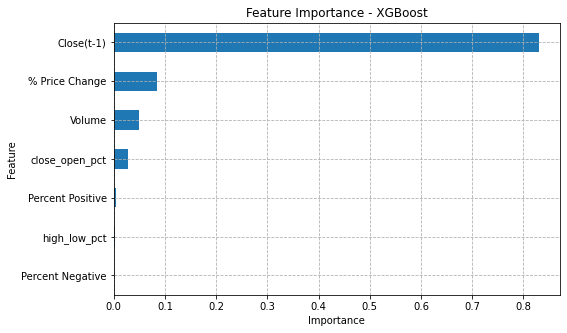

In [10]:
xgb_importance = xgb_model.feature_importances_

xgb_importance = pd.Series(xgb_importance, index=predictors).sort_values(ascending=True)

xgb_importance.plot(kind='barh',
                    figsize=(8,5),
                    title="Feature Importance - XGBoost",
                    xlabel="Feature")

plt.xlabel("Importance")
plt.grid(which="both", linestyle="--")
plt.show()

# plt.savefig("./images/xgb_importance.jpg")

### SVR

In [11]:
from sklearn.svm import SVR

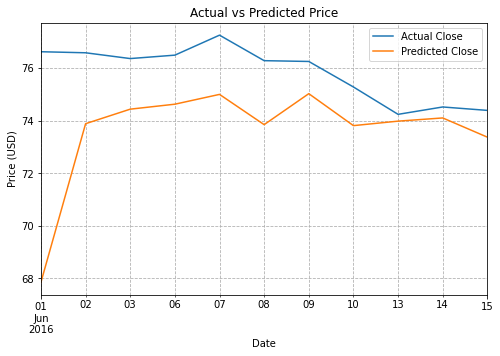

In [12]:
svr_model = SVR(kernel="rbf")
svr_model.fit(X_train_scaled, train["Close"].values)
closing_pred = svr_model.predict(X_test_scaled)

closing_pred = pd.Series(closing_pred, index=test.index, name="Predicted Close")

comparison = pd.concat([test["Close"], closing_pred], axis=1,)
comparison.rename({"Close": "Actual Close"}, axis=1, inplace=True)

comparison.plot(figsize=(8,5),
                title="Actual vs Predicted Price",
                ylabel="Price (USD)")
plt.grid(which="both", linestyle="--")
plt.show()

In [13]:
regression_metrics(test["Close"], closing_pred)

R^2: -8.813935915550342
Mean Squared Error: 9.740052315451628
Mean Absolute Error: 2.21050965333569
Root MSE: 3.1209056883301725
% MAE: 0.028952597395979038
